In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.special import boxcox1p
import pickle
from os import path
import statsmodels.api as sm
import warnings
import torch
import transformers


warnings.filterwarnings("ignore")

# data Visualization
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import plotly.express as px 
#from plotnine import ggplot, aes, geom_line, geom_point, facet_wrap, theme
import plotly.graph_objects as go
# Machine learning algorithms and model evaluation
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from skforecast.model_selection import backtesting_forecaster
#from skforecast.model_selection import grid_search_forecaster
#from skforecast.model_selection import bayesian_search_forecaster
#from lightgbm import LGBMRegressor
# Encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler



1. Data Preprocessing:
Load the datasets


In [ ]:
# Load the three datasets
average_hours = pd.read_csv('Resources/average-usual-weekly-hours-worked-women-15-years-and-older.csv')
employment_ratio = pd.read_csv("Resources/female-employment-to-population-ratio.csv")
wage_gap = pd.read_csv("Resources/gender-wage-gap-oecd.csv")
percapita_labor = pd.read_csv("Resources/female-labor-force-participation-rates-by-national-per-capita-income.csv")
school_years = pd.read_csv("Resources/mean-years-of-schooling-female.csv")
maternity_leave = pd.read_csv("Resources/paid-leave-at-least-14-weeks-mothers.csv")
labor_sector = pd.read_csv("Resources/share-of-female-workers-by-sector.csv")


In [ ]:
# View the Columns and Rows for each of the dataset 
print(f'Shape of average_hours DataFrame: {average_hours.shape}')
print(f'Shape of employment_ratio DataFrame: {employment_ratio.shape}')
print(f'Shape of wage_gap DataFrame: {wage_gap.shape}')
print(f'Shape of percapita_labor DataFrame: {percapita_labor.shape}')
print(f'Shape of school_years DataFrame: {school_years.shape}')
print(f'Shape of maternity_leave DataFrame: {maternity_leave.shape}')
print(f'Shape of labor_sector DataFrame: {labor_sector.shape}')

In [ ]:
# Rename Columns to make it shorter
average_hours = average_hours.rename(columns={'Average weekly hours worked (women, 15+) (OECD Labor Force Statistics (2017))': 'Avg_Hours_Worked'})
employment_ratio = employment_ratio.rename(columns={'Employment to population ratio, 15+, female (%) (national estimate)': 'Emp_Pop_Ratio'})
wage_gap = wage_gap.rename(columns={'Gender wage gap (OECD 2017)': 'Gender_Wage_Gap'})
percapita_labor = percapita_labor.rename(columns={'Labor force participation rate, female (% of female population ages 15+) (modeled ILO estimate)': 'Labor_Force'})
school_years = school_years.rename(columns={'Mean years of schooling (ISCED 1 or higher), population 25+ years, female': 'School_Years_Mean'})
maternity_leave = maternity_leave.rename(columns={'Paid leave of at least 14 weeks available to mothers (1=yes; 0=no)': 'Paid_Leave'})
labor_sector = labor_sector.rename(columns={'Female share of employment in agriculture (%)': 'Argiculture','Female share of employment in industry (%)': 'Industry','Female share of employment in services (%)': 'Services'})


In [ ]:
# Drop Null Values from these two datasets 
average_hours.dropna(inplace=True)
employment_ratio.dropna(inplace=True)


In [ ]:
# Merge the datasets
merged_df= average_hours.merge(employment_ratio, on=['Entity', 'Code', 'Year'], how='outer')
merged_df= merged_df .merge(wage_gap, on=['Entity', 'Code', 'Year'], how='outer')
merged_df= merged_df .merge(percapita_labor, on=['Entity', 'Code', 'Year'], how='outer')
merged_df= merged_df .merge(school_years, on=['Entity', 'Code', 'Year'], how='outer')
merged_df= merged_df .merge(maternity_leave, on=['Entity', 'Code', 'Year'], how='outer')
merged_df= merged_df .merge(labor_sector, on=['Entity', 'Code', 'Year'], how='outer')

# Check the result
print(merged_df.shape)


In [ ]:
# Check for null values 
print(merged_df.isnull().sum())

In [ ]:
#Drop colum "Continent"
merged_df = merged_df.drop("Continent", axis=1)

In [ ]:
# Check for duplicates
duplicates = merged_df.duplicated().sum()
print(f"Number of duplicates: {duplicates}")

In [ ]:
# Filter rows with less than <= 3 letters
filtered_df = merged_df[merged_df['Code'].str.len()<=3]


In [ ]:
# Check the data types of each column
print(filtered_df.dtypes)


In [ ]:
# Perform some basic EDA- View the dataset's distribution
print(filtered_df.describe())


Handle Null Values using the KNNImputer. For KNNImputer can only work on numerical columns. 
First step is to define numerical and catrgorical columns and then train only on the numerical columns. 

In [ ]:
# Define numerical and catrgorical columns 
numerical_cols = ['Year', 'Avg_Hours_Worked', 'Emp_Pop_Ratio', 'Gender_Wage_Gap', 
                  'Labor_Force', 'GDP per capita, PPP (constant 2017 international $)', 
                  'School_Years_Mean', 'Paid_Leave', 'Argiculture', 'Industry', 
                  'Services']

categorical_cols = ['Entity', 'Code']

In [ ]:
# Train on the numerical columns with n_neighbor =5
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder

# Impute null values in numerical columns using KNNImputer
imputer_num = KNNImputer(n_neighbors=5)
imputed_num_data = imputer_num.fit_transform(filtered_df[numerical_cols])

# One-Hot Encode categorical columns
#ohe = OneHotEncoder(handle_unknown='ignore')
#encoded_array = ohe.fit_transform(filtered_df[categorical_cols])
#encoded_df = pd.DataFrame(encoded_array.toarray(), columns=ohe.get_feature_names_out(categorical_cols))

# Concatenate imputed numerical columns with one-hot encoded categorical columns
#df_encoded = pd.concat([pd.DataFrame(imputed_num_data, columns=numerical_cols), encoded_df], axis=1)


In [ ]:
# Check for null values before imputation
print("Null values before imputation:")
print(filtered_df[numerical_cols].isnull().sum())

#imputed_num_data = imputer_num.fit_transform(filtered_df[numerical_cols])

# Check null values after the imputation 
imputed_num_df = pd.DataFrame(imputed_num_data, columns=numerical_cols)
imputed_num_df.reset_index(inplace=True, drop=True)
cat_df= filtered_df[categorical_cols]
cat_df.reset_index(inplace=True, drop=True)

print(cat_df.isnull().sum())
print("Null values after imputation:")
print(imputed_num_df.isnull().sum())

Given that the KNNimputer was only used on the numerical columns, we have to use concate function to add the categorical columns to the imputed dataframe. 

In [ ]:
# concatenate the imputed numerical columns with the original categorical columns
# pd.DataFrame(imputed_num_data, columns=numerical_cols)
imputed_df = pd.concat([imputed_num_df, cat_df], axis=1)
#imputed_df[categorical_cols] = imputed_df[categorical_cols].astype('category')

In [ ]:
# View the new datset
imputed_df

In [ ]:
# Check for null values after concating the numerical and categorical columns
print(imputed_df.isnull().sum())

In [ ]:
# Convert Code to ISO Numeric Values

# Update Country Code to the ISO numeric value
country_code_dict = {
"AFG":4,"ALA":248,"ALB":8,"DZA":12,"ASM":16,"AND":20,"AGO":24,"AIA":660,"ATA":10,"ATG":28,"ARG":32,"ARM":51,
"ABW":533,"AUS":36,"AUT":40,"AZE":31,"BHS":44,"BHR":48,"BGD":50,"BRB":52,"BLR":112,"BEL":56,"BLZ":84,"BEN":204,
"BMU":60,"BTN":64,"BOL":68,"BIH":70,"BWA":72,"BVT":74,"BRA":76,"IOT":86,"BRN":96,"BGR":100,"BFA":854,"BDI":108,
"KHM":116,"CMR":120,"CAN":124,"CPV":132,"CYM":136,"CAF":140,"TCD":148,"CHL":152,"CHN":156,"CXR":162,"CCK":166,
"COL":170,"COM":174,"COG":178,"COD":180,"COK":184,"CRI":188,"CIV":384,"HRV":191,"CUB":192,"CYP":196,"CZE":203,
"DNK":208,"DJI":262,"DMA":212,"DOM":214,"ECU":218,"EGY":818,"SLV":222,"GNQ":226,"ERI":232,"EST":233,"ETH":231,
"FLK":238,"FRO":234,"FJI":242,"FIN":246,"FRA":250,"GUF":254,"PYF":258,"ATF":260,"GAB":266,"GMB":270,"GEO":268,
"DEU":276,"GHA":288,"GIB":292,"GRC":300,"GRL":304,"GRD":308,"GLP":312,"GUM":316,"GTM":320,"GGY":831,"GIN":324,
"GNB":624,"GUY":328,"HTI":332,"HMD":334,"VAT":336,"HND":340,"HKG":344,"HUN":348,"ISL":352,"IND":356,"IDN":360,
"IRN":364,"IRQ":368,"IRL":372,"IMN":833,"ISR":376,"ITA":380,"JAM":388,"JPN":392,"JEY":832,"JOR":400,"KAZ":398,
"KEN":404,"KIR":296,"PRK":408,"KOR":410,"KWT":414,"KGZ":417,"LAO":418,"LVA":428,"LBN":422,"LSO":426,"LBR":430,
"LBY":434,"LIE":438,"LTU":440,"LUX":442,"MAC":446,"MKD":807,"MDG":450,"MWI":454,"MYS":458,"MDV":462,"MLI":466,
"MLT":470,"MHL":584,"MTQ":474,"MRT":478,"MUS":480,"MYT":175,"MEX":484,"FSM":583,"MDA":498,"MCO":492,"MNG":496,
"MNE":499,"MSR":500,"MAR":504,"MOZ":508,"MMR":104,"NAM":516,"NRU":520,"NPL":524,"NLD":528,"ANT":530,"NCL":540,
"NZL":554,"NIC":558,"NER":562,"NGA":566,"NIU":570,"NFK":574,"MNP":580,"NOR":578,"OMN":512,"PAK":586,"PLW":585,
"PSE":275,"PAN":591,"PNG":598,"PRY":600,"PER":604,"PHL":608,"PCN":612,"POL":616,"PRT":620,"PRI":630,"QAT":634,
"REU":638,"ROU":642,"RUS":643,"RWA":646,"BLM":652,"SHN":654,"KNA":659,"LCA":662,"MAF":663,"SPM":666,"VCT":670,
"WSM":882,"SMR":674,"STP":678,"SAU":682,"SEN":686,"SRB":688,"SYC":690,"SLE":694,"SGP":702,"SVK":703,"SVN":705,
"SLB":90,"SOM":706,"ZAF":710,"SGS":239,"ESP":724,"LKA":144,"SDN":736,"SUR":740,"SJM":744,"SWZ":748,"SWE":752,
"CHE":756,"SYR":760,"TWN":158,"TJK":762,"TZA":834,"THA":764,"TLS":626,"TGO":768,"TKL":772,"TON":776,"TTO":780,
"TUN":788,"TUR":792,"TKM":795,"TCA":796,"TUV":798,"UGA":800,"UKR":804,"ARE":784,"GBR":826,"USA":840,"UMI":581,
"URY":858,"UZB":860,"VUT":548,"VEN":862,"VNM":704,"VGB":92,"VIR":850,"WLF":876,"ESH":732,"YEM":887,"ZMB":894,
"ZWE":716,"EMU":1,"XKX":2,"SSD":3
}

imputed_df_code = imputed_df.replace({"Code": country_code_dict})

imputed_df_code.head(50)

# imputed_df_code.to_csv('imputed_data_with_country_codes.csv', index=False)

Perform basic EDA (Exploratory Data Analysis)
Top 10 Countries for each of the features 


In [ ]:
# Get the top 10 countries by Average Hours Worked  
top_countries = imputed_df.groupby('Entity')['Avg_Hours_Worked'].mean().reset_index()
top_countries = top_countries.nlargest(10, 'Avg_Hours_Worked')

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(top_countries['Entity'], top_countries['Avg_Hours_Worked'])
plt.title("Top 10 Countries by Avg_Hours_Worked")
plt.xlabel("Avg_Hours_Worked")
plt.ylabel("Country")
plt.show()

In [ ]:
# Get the top 10 countries by Emp_Pop_Ratio  
top_countries = imputed_df.groupby('Entity')['Emp_Pop_Ratio'].mean().reset_index()
top_countries = top_countries.nlargest(10, 'Emp_Pop_Ratio')

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(top_countries['Entity'], top_countries['Emp_Pop_Ratio'])
plt.title("Top 10 Countries by Emp_Pop_Ratio")
plt.xlabel("Emp_Pop_Ratio")
plt.ylabel("Country")
plt.show()

In [ ]:
# Get the top 10 countries by Gender_Wage_Gap
top_countries = merged_df.groupby('Entity')['Gender_Wage_Gap'].mean().reset_index()
top_countries = top_countries.nlargest(10, 'Gender_Wage_Gap')

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(top_countries['Entity'], top_countries['Gender_Wage_Gap'])
plt.title("Top 10 Countries by Gender_Wage_Gap")
plt.xlabel("Gender_Wage_Gap")
plt.ylabel("Country")
plt.show()

In [ ]:
# Get the top 10 countries by Argiculture
top_countries = merged_df.groupby('Entity')['Argiculture'].mean().reset_index()
top_countries = top_countries.nlargest(10, 'Argiculture')

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(top_countries['Entity'], top_countries['Argiculture'])
plt.title("Top 10 Countries Female share of employment in Agriculture")
plt.xlabel("Argiculture")
plt.ylabel("Country")
plt.show()

In [ ]:
# Get the top 10 countries by Industry
top_countries = merged_df.groupby('Entity')['Industry'].mean().reset_index()
top_countries = top_countries.nlargest(10, 'Industry')

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(top_countries['Entity'], top_countries['Industry'])
plt.title("Top 10 Countries by Female share of employment in industry")
plt.xlabel("Industry(%)")
plt.ylabel("Country")
plt.show()

In [ ]:
# Get the top 10 countries by Services
top_countries = merged_df.groupby('Entity')['Services'].mean().reset_index()
top_countries = top_countries.nlargest(10, 'Services')

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(top_countries['Entity'], top_countries['Services'])
plt.title("Top 10 Countries  by Female share of employment in services")
plt.xlabel("Services(%)")
plt.ylabel("Country")
plt.show()

BASIC EDA: Bottom 10 Countries for each of the features

In [ ]:

# Get the bottom 10 countries by average hours worked
bottom_countries = merged_df.groupby('Entity')['Avg_Hours_Worked'].mean().reset_index()
bottom_countries = bottom_countries.nsmallest(10, 'Avg_Hours_Worked')

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(bottom_countries['Entity'], bottom_countries['Avg_Hours_Worked'])
plt.title("Bottom 10 Countries by Average Hours Worked")
plt.xlabel("Average Hours Worked")
plt.ylabel("Country")
plt.show()

In [ ]:
# Get the top 10 countries by Services
bottom_countries = merged_df.groupby('Entity')['Services'].mean().reset_index()
bottom_countries = bottom_countries.nsmallest(10, 'Services')

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(bottom_countries['Entity'], bottom_countries['Services'])
plt.title("Bottom 10 Countries by Female in Services")
plt.xlabel("Services")
plt.ylabel("Country")
plt.show()

CREATE A PROFESSIONAL WELLBEING SCORE 0-1

In [ ]:
# Define the columns that will be used to create the professional wellbeing score
columns_to_use = ['Avg_Hours_Worked', 'Emp_Pop_Ratio', 'Gender_Wage_Gap', 
                  'Labor_Force', 'GDP per capita, PPP (constant 2017 international $)', 
                  'School_Years_Mean', 'Paid_Leave', 'Argiculture', 'Industry', 
                  'Services']

# Scale the columns using Min-Max Scaler to have values between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
imputed_df[columns_to_use] = scaler.fit_transform(imputed_df[columns_to_use])

# Calculate the professional wellbeing score as the average of the scaled columns
imputed_df['Professional_Wellbeing_Score'] = imputed_df[columns_to_use].mean(axis=1)

Scale the columns

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
imputed_df[columns_to_use] = scaler.fit_transform(imputed_df[columns_to_use])

Split the data into training and testing sets

In [ ]:
from sklearn.model_selection import train_test_split

X = imputed_df[columns_to_use]
y = imputed_df['Professional_Wellbeing_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Model Development #1 
RandomForestRegressor

In [51]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score,make_scorer

# Define the features and target
# Replace with your feature columns columns_to_use = [...]  
X = imputed_df[columns_to_use]
y = imputed_df['Professional_Wellbeing_Score']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
rf = RandomForestRegressor()

# Define the parameter grid
param_dist = {
    'n_estimators': np.arange(10, 200, 10),
    'max_depth': [None] + list(np.arange(1, 20, 2)),
    'min_samples_split': np.arange(2, 10, 1),
    'min_samples_leaf': np.arange(1, 10, 1),
    'max_features': [1.0, 'sqrt', 'log2']  # Avoid using 'auto'
}

# Instantiate the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings sampled
    cv=5,        # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1    # Use all available cores
)

# Fit the random search model
random_search.fit(X_train, y_train)

# Display the best parameters found
print("Best parameters found: ", random_search.best_params_)

# Predict using the best model
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Calculate and display the mean squared error
mse = mean_squared_error(y_test, y_pred)
r2_best = r2_score(y_test, y_pred)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'n_estimators': 120, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}


Model Development #2
LightGBM Regressor (LGBMRegressor)

In [52]:
imputed_df.columns

Index(['Year', 'Avg_Hours_Worked', 'Emp_Pop_Ratio', 'Gender_Wage_Gap',
       'Labor_Force', 'GDP per capita, PPP (constant 2017 international $)',
       'School_Years_Mean', 'Paid_Leave', 'Argiculture', 'Industry',
       'Services', 'Entity', 'Code', 'Professional_Wellbeing_Score'],
      dtype='object')

In [54]:
from lightgbm import LGBMRegressor
import pandas as pd

imputed_df_copy = imputed_df.copy()
# Clean column names in the DataFrame
imputed_df_copy.columns = imputed_df_copy.columns.str.replace('[^a-zA-Z0-9]', '_', regex=True)

# Corrected list of columns to use (based on the cleaned column names)
corrected_columns_to_use = ['Avg_Hours_Worked', 'Emp_Pop_Ratio', 'Gender_Wage_Gap', 
                            'Labor_Force', 'GDP_per_capita__PPP__constant_2017_international___', 
                            'School_Years_Mean', 'Paid_Leave', 'Argiculture', 'Industry', 
                            'Services']

# Define the features and target
X = imputed_df_copy[corrected_columns_to_use]
y = imputed_df_copy['Professional_Wellbeing_Score']

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
lgb_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the model
lgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_lgb = lgb_model.predict(X_test)

# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2301
[LightGBM] [Info] Number of data points in the train set: 8622, number of used features: 10
[LightGBM] [Info] Start training from score 0.435463


Model #3 Linear Regression

In [55]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

Model #4 Gradient Boosting Regressor

In [57]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)

In [58]:
#Hyperparameter Tuning for Gradient Boosting Regressor

from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': np.arange(50, 251, 50),
    'learning_rate': np.linspace(0.01, 0.2, 10),
    'max_depth': np.arange(3, 8),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 11)
}

gb_model = GradientBoostingRegressor(random_state=42)

random_search = RandomizedSearchCV(estimator=gb_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_model = random_search.best_estimator_

y_pred_best = best_model.predict(X_test)

mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print("Best Parameters:", best_params)
print("MSE:", mse_best)
print("R2:", r2_best)

Best Parameters: {'n_estimators': 250, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_depth': 4, 'learning_rate': 0.11555555555555555}
MSE: 3.0609370876092964e-05
R2: 0.9943086576700437


Model #5 XGBoost Regressor

In [59]:
# Initialize the XGBRegressor model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_xgb = xgb_model.predict(X_test)

In [61]:
 # Hyperparameter Tuning for XGBoost Regressor

param_dist_xgb = {
    'n_estimators': np.arange(50, 251, 50),
    'learning_rate': np.linspace(0.01, 0.2, 10),
    'max_depth': np.arange(3, 8),
    'subsample': np.linspace(0.5, 1.0, 6),
    'colsample_bytree': np.linspace(0.5, 1.0, 6),
    'min_child_weight': np.arange(1, 11)
}

random_search_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist_xgb, n_iter=10, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
random_search_xgb.fit(X_train, y_train)

best_params_xgb = random_search_xgb.best_params_
best_model_xgb = random_search_xgb.best_estimator_

y_pred_best_xgb = best_model_xgb.predict(X_test)

mse_best_xgb = mean_squared_error(y_test, y_pred_best_xgb)
r2_best_xgb = r2_score(y_test, y_pred_best_xgb)

print("\nXGBoost Regressor Best Parameters:", best_params_xgb)
print("MSE:", mse_best_xgb)
print("R2:", r2_best_xgb)


XGBoost Regressor Best Parameters: {'subsample': 0.5, 'n_estimators': 250, 'min_child_weight': 10, 'max_depth': 6, 'learning_rate': 0.09444444444444444, 'colsample_bytree': 0.7}
MSE: 2.2772498559815083e-05
R2: 0.9957658036966198


Results for Models used

In [64]:
from sklearn.metrics import mean_squared_error, r2_score


print("Random Forest Regressor:")
print("Mean Squared Error: ", mse)
print("R² Score: ", r2_best)


print("LGBMRegressor:")
print(f"LightGBM MSE: {mse_lgb}")
print(f"LightGBM R2 Score: {r2_lgb}")


print("Linear Regression:")
print("MSE:", mean_squared_error(y_test, y_pred_lr))
print("R2:", r2_score(y_test, y_pred_lr))


print("\nGradient Boosting Regressor:")
print("MSE:", mean_squared_error(y_test, y_pred_gb))
print("R2:", r2_score(y_test, y_pred_gb))


print("\nXGBoost Regressor:")
print("MSE:", mean_squared_error(y_test, y_pred_xgb))
print("R2:", r2_score(y_test, y_pred_xgb))

Random Forest Regressor:
Mean Squared Error:  6.047269393367815e-05
R² Score:  0.9943086576700437
LGBMRegressor:
LightGBM MSE: 3.9479925593837536e-05
LightGBM R2 Score: 0.9926593142791044
Linear Regression:
MSE: 6.22747124967587e-32
R2: 1.0

Gradient Boosting Regressor:
MSE: 6.958849219496495e-05
R2: 0.9870610888113232

XGBoost Regressor:
MSE: 4.445643726121712e-05
R2: 0.9917340083777603


Model #6 Neural Networks with relu 

In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# Define the input features (X) and the target variable (y)
X = imputed_df[columns_to_use]
y = imputed_df['Professional_Wellbeing_Score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Output layer with a single neuron

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

Epoch 1/50
270/270 - 1s - 4ms/step - loss: 0.0061
Epoch 2/50
270/270 - 0s - 837us/step - loss: 0.0011
Epoch 3/50
270/270 - 0s - 807us/step - loss: 6.3954e-04
Epoch 4/50
270/270 - 0s - 835us/step - loss: 4.3615e-04
Epoch 5/50
270/270 - 0s - 812us/step - loss: 3.1695e-04
Epoch 6/50
270/270 - 0s - 802us/step - loss: 2.4002e-04
Epoch 7/50
270/270 - 0s - 842us/step - loss: 1.8538e-04
Epoch 8/50
270/270 - 0s - 821us/step - loss: 1.5284e-04
Epoch 9/50
270/270 - 0s - 812us/step - loss: 1.2623e-04
Epoch 10/50
270/270 - 0s - 821us/step - loss: 1.1055e-04
Epoch 11/50
270/270 - 0s - 835us/step - loss: 8.9968e-05
Epoch 12/50
270/270 - 0s - 826us/step - loss: 7.9780e-05
Epoch 13/50
270/270 - 0s - 860us/step - loss: 6.7257e-05
Epoch 14/50
270/270 - 0s - 850us/step - loss: 5.7344e-05
Epoch 15/50
270/270 - 0s - 873us/step - loss: 5.3768e-05
Epoch 16/50
270/270 - 0s - 852us/step - loss: 4.4757e-05
Epoch 17/50
270/270 - 0s - 826us/step - loss: 3.8603e-05
Epoch 18/50
270/270 - 0s - 827us/step - loss: 3.60

In [66]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Flatten y_pred and y_test to 1-dimensional arrays
y_pred = y_pred.flatten()
y_test = y_test.values.flatten()

# Evaluate the model using Mean Squared Error (MSE)
mse = np.mean((y_pred - y_test) ** 2)
print("MSE:", mse)

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
MSE: 3.1532921568419493e-06


In [ ]:
imputed_df

Professional Wellbeing App using Gradio 

In [67]:
import gradio as gr

def get_professional_wellbeing_score(entity_name):
    # Search for the entity name in the dataset
    entity_row = imputed_df[imputed_df["Entity"] == entity_name]
    if entity_row.empty:
        print(f"Entity '{entity_name}' not found in dataset")
        return "Entity not found"
    else:
        # Return the professional wellbeing score for the entity
        print(f"Entity '{entity_name}' found in dataset")
        return entity_row["Professional_Wellbeing_Score"].values[0]

# Create the Gradio app
gr_interface = gr.Interface(
    fn=get_professional_wellbeing_score,
    inputs="text",
    outputs="text",
    title="Professional Wellbeing Score Lookup",
    description="Enter an entity name to get its professional wellbeing score"
)

# Launch the Gradio app
gr_interface.launch()

Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


Budiling the gradio app to work with LLM to provide explaination and suggestion for each country's professional wellbeing score. 

In [68]:
import gradio as gr
import os
import requests
from dotenv import load_dotenv
import pandas as pd
import numpy as np

# Load the API key from the environment variable
load_dotenv()
openai_api_key = os.getenv('OPENAI_API_KEY')

if not openai_api_key:
    raise ValueError("OpenAI API key not found. Please set it in your .env file.")

headers = {
    'Authorization': f'Bearer {openai_api_key}',
    'Content-Type': 'application/json',
}

Defining the Explainations and Suggestions outputs

In [69]:
def generate_explanations(entity_name):
    entity_row = imputed_df[imputed_df["Entity"] == entity_name]
    
    # Calculate the average values of the features across all entities, excluding 'Year'
    average_values = imputed_df.select_dtypes(include=['number']).drop('Year', axis=1).mean()
 
    
    # Identify the features that are higher or lower for the entity compared to the average
    explanations = []
    for feature in entity_row.columns:
        if feature != "Entity" and feature != "Professional_Wellbeing_Score" and feature != 'Year' and entity_row[feature].dtype.kind in 'bifc':
            if entity_row[feature].values[0] > average_values[feature]:
                explanations.append(f"The entity has a higher value for {feature} compared to the average, which is associated with higher professional wellbeing scores.")
            elif entity_row[feature].values[0] < average_values[feature]:
                explanations.append(f"The entity has a lower value for {feature} compared to the average, which is associated with higher professional wellbeing scores.")
    
    # Define the professional score as high or low on a scale of 0-1
    wellbeing_score = entity_row["Professional_Wellbeing_Score"].values[0]
    if wellbeing_score >= 0.5:
        wellbeing_score_label = "high"
    else:
        wellbeing_score_label = "low"
    
    # Generate a paragraph explaining the professional wellbeing score
    explanation_paragraph = f"The entity {entity_name} has a professional wellbeing score of {wellbeing_score:.2f}, which is considered {wellbeing_score_label}. "
    explanation_paragraph += "The following factors contribute to this score: "
    explanation_paragraph += ", ".join(explanations)
    
    return explanation_paragraph

def generate_suggestions(entity_name):
    wellbeing_score = get_professional_wellbeing_score(entity_name)
    explanations = generate_explanations(entity_name)
    
    # Create a prompt for the LLM model
    prompt = f"Generate suggestions to improve professional wellbeing of women in {entity_name} based on the following explanations: {', '.join(explanations)}"
    
    data = {
        "model": "gpt-3.5-turbo",
        "messages": [
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ],
        "max_tokens": 1024
    }

    try:
        response = requests.post('https://api.openai.com/v1/chat/completions', headers=headers, json=data)
        response.raise_for_status()
        result = response.json()
        suggestions = result['choices'][0]['message']['content'].strip()
        return suggestions
    except requests.exceptions.HTTPError as err:
        return f"HTTP error occurred: {err}"
    except Exception as e:
        return f"An error occurred: {e}"

In [70]:
# Create the Gradio app
gr_interface = gr.Interface(
    fn=lambda entity_name: (
        get_professional_wellbeing_score(entity_name),
        generate_explanations(entity_name),
        generate_suggestions(entity_name)
    ),
    inputs="text",
    outputs=["text", "text", "text"],
    title="Professional Wellbeing Score Lookup and Suggestions",
    description="Enter an entity name to get its professional wellbeing score, explanations, and suggestions for improvement"
)

# Launch the Gradio app
gr_interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7863

Thanks for being a Gradio user! If you have questions or feedback, please join our Discord server and chat with us: https://discord.gg/feTf9x3ZSB
Running on public URL: https://1f597af77772bdd7b3.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Entity 'France' found in dataset
Entity 'France' found in dataset


Top 10 unique entities with the highest professional wellbeing scores:
          Entity  Professional_Wellbeing_Score
3624     Vietnam                      0.669681
1323    Cameroon                      0.656106
5269  Kazakhstan                      0.649253
2573       Niger                      0.640200
753     Slovenia                      0.639434
1046  Azerbaijan                      0.639434
1428       Congo                      0.637377
1747     Georgia                      0.636732
2302  Madagascar                      0.632285
729      Romania                      0.631117


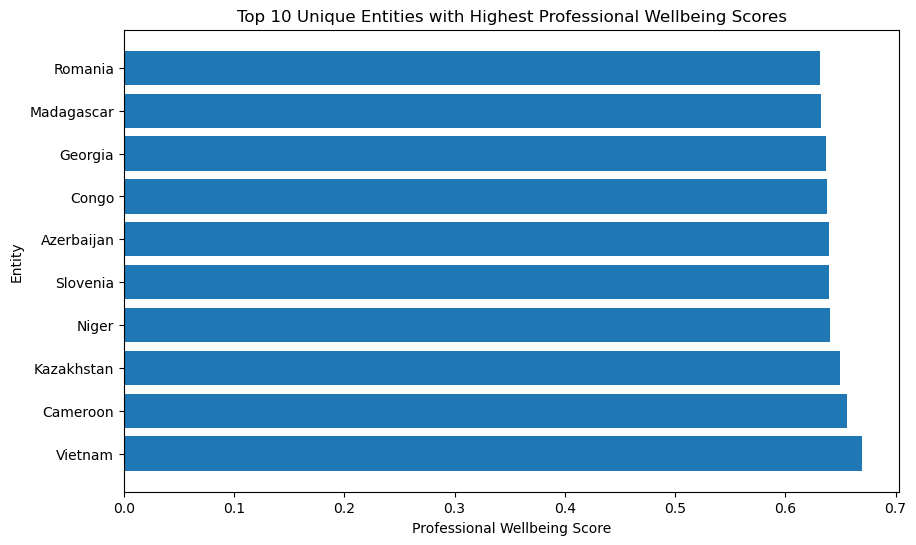

In [71]:
import matplotlib.pyplot as plt

# Get the unique entities with the highest professional wellbeing scores
unique_entities = imputed_df.sort_values('Professional_Wellbeing_Score', ascending=False).drop_duplicates('Entity')[['Entity', 'Professional_Wellbeing_Score']].head(10)

print("Top 10 unique entities with the highest professional wellbeing scores:")
print(unique_entities)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the unique entities
ax.barh(unique_entities['Entity'], unique_entities['Professional_Wellbeing_Score'])

# Set title and labels
ax.set_title('Top 10 Unique Entities with Highest Professional Wellbeing Scores')
ax.set_xlabel('Professional Wellbeing Score')
ax.set_ylabel('Entity')

# Show the plot
plt.show()

Top 10 unique entities with the lowest professional wellbeing scores:
             Entity  Professional_Wellbeing_Score
1588          Egypt                      0.184196
1071        Bahrain                      0.197284
2641       Pakistan                      0.202132
2999   Saudi Arabia                      0.209824
10369         Syria                      0.211607
1095     Bangladesh                      0.223750
2194         Kuwait                      0.230665
2162         Jordan                      0.233423
10512        Turkey                      0.236847
6087           Oman                      0.255147


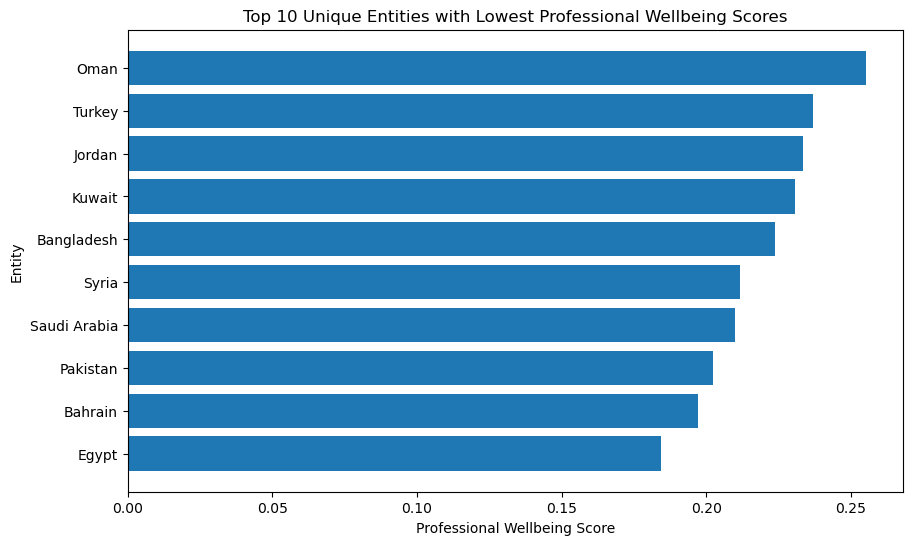

In [72]:
# Get the unique entities with the lowest professional wellbeing scores
unique_entities = imputed_df.sort_values('Professional_Wellbeing_Score').drop_duplicates('Entity')[['Entity', 'Professional_Wellbeing_Score']].head(10)

print("Top 10 unique entities with the lowest professional wellbeing scores:")
print(unique_entities)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the unique entities
ax.barh(unique_entities['Entity'], unique_entities['Professional_Wellbeing_Score'])

# Set title and labels
ax.set_title('Top 10 Unique Entities with Lowest Professional Wellbeing Scores')
ax.set_xlabel('Professional Wellbeing Score')
ax.set_ylabel('Entity')

# Show the plot
plt.show()